<a href="https://colab.research.google.com/github/matuseho/Simporter_TestTask/blob/master/Simporter_Test_Task%2C_Mnukhina____750k_rows_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import string
import wordcloud
%matplotlib inline
import re
import gzip
import itertools

import nltk 
from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec                                   #For Word2Vec

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn import decomposition, ensemble

from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from spacy import displacy
from spacy.util import minibatch, compounding

import warnings
warnings.simplefilter('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/My Drive

/content/drive/My Drive


### Загружаем данные

In [0]:
reviews_data = pd.read_json('reviews.json', orient = 'values', lines = True)

In [5]:
reviews_data.head(5)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,4,False,"05 1, 2015",A8WEXFRWX1ZHH,0209688726,{'Color:': ' AC'},Goldengate,"After I wrote the below review, the manufactur...",Works well if you place phone in horizontally ...,1430438400,NaN,NaN
1,1,True,"04 19, 2018",ABCA1A8E4DGV1,0209688726,{'Color:': ' Blue'},noe,It sucks barely picks up anything definitely n...,sucks,1524096000,NaN,NaN
2,1,True,"04 16, 2018",A1NX8HM89FRQ32,0209688726,{'Color:': ' Black'},Eduard,"Well to write a short one, it blew 2 fuses of ...",Defective,1523836800,NaN,NaN
3,3,True,"04 13, 2018",A1X77G023NY0KY,0209688726,{'Color:': ' CA'},Lauren,I have absolutely no memory of buying this but...,Looks cool! Probably works,1523577600,NaN,NaN
4,5,True,"04 8, 2018",A3GK37JO2MGW6Q,0209688726,{'Color:': ' Black'},danny,it ok it does it job,Five Stars,1523145600,NaN,NaN


### Важно!
И ноуту, и колабу довольно тяжело справиться с объёмом данных, когда наступает время строить и оценивать модель, так что придётся уменьшить исходный датасет.

### Оставляем только reviewText и summary

In [0]:
reviews = reviews_data.loc[:,['overall', 'reviewText']].head(750000)

In [0]:
# бэкап на всякий случай
rev2 = reviews.copy(deep = True)

In [0]:
# откат к бэкапу, если нужно
reviews = rev2.copy(deep = True)

In [9]:
reviews

,overall,reviewText
0,4,"After I wrote the below review, the manufactur..."
1,1,It sucks barely picks up anything definitely n...
2,1,"Well to write a short one, it blew 2 fuses of ..."
3,3,I have absolutely no memory of buying this but...
4,5,it ok it does it job
...,...,...
749995,5,Cord is of a decent length. It charged up my m...
749996,5,I needed a charger to charge a gel-cell 12v ba...
749997,5,So far so good. Simple and effective.
749998,5,"as expected, great product, i own 3 of this, a..."


## Предобработка

In [10]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 2 columns):
overall       750000 non-null int64
reviewText    749756 non-null object
dtypes: int64(1), object(1)
memory usage: 11.4+ MB


Есть пустые отзывы, нужно будет убрать

In [11]:
reviews.describe()

,overall
count,750000.000000
mean,4.492281
std,1.008919
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


Классы не сбалансированны совершенно


### Убираем пустые записи

In [12]:
reviews = reviews.dropna()
reviews

,overall,reviewText
0,4,"After I wrote the below review, the manufactur..."
1,1,It sucks barely picks up anything definitely n...
2,1,"Well to write a short one, it blew 2 fuses of ..."
3,3,I have absolutely no memory of buying this but...
4,5,it ok it does it job
...,...,...
749995,5,Cord is of a decent length. It charged up my m...
749996,5,I needed a charger to charge a gel-cell 12v ba...
749997,5,So far so good. Simple and effective.
749998,5,"as expected, great product, i own 3 of this, a..."


### Убираем дупликаты записей

In [13]:
reviews = reviews.drop_duplicates(subset=['reviewText'])
reviews

,overall,reviewText
0,4,"After I wrote the below review, the manufactur..."
1,1,It sucks barely picks up anything definitely n...
2,1,"Well to write a short one, it blew 2 fuses of ..."
3,3,I have absolutely no memory of buying this but...
4,5,it ok it does it job
...,...,...
749995,5,Cord is of a decent length. It charged up my m...
749996,5,I needed a charger to charge a gel-cell 12v ba...
749997,5,So far so good. Simple and effective.
749998,5,"as expected, great product, i own 3 of this, a..."


In [14]:
reviews.describe()

,overall
count,570612.000000
mean,4.446419
std,1.054806
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


Лучше не стало. Значит, при построении модели будем это учитывать и соответствущим образом строить тренировочный датасет

### Приводим к нижнему регистру

In [15]:
reviews["reviewText"] = reviews["reviewText"].str.lower()
reviews.head()

,overall,reviewText
0,4,"after i wrote the below review, the manufactur..."
1,1,it sucks barely picks up anything definitely n...
2,1,"well to write a short one, it blew 2 fuses of ..."
3,3,i have absolutely no memory of buying this but...
4,5,it ok it does it job


### Убираем цифры

Нас интересуют не только числа, но и слова, в которых затесались цифры. Есть два варианта исправить ситуацию -- убрать такие слова полностью или лишь удалить из них цифры (предполагая, например, что это описка или незажатый Shift при выборе знака препинания). Остановлюсь на втором варианте

In [16]:
# Пример

s= '57 h34h fkk233 833eweh23n323k23 sdd8d8a9f0h0e0s6d6g8sd8f6s8f ggg666gg'

print(re.sub("\S*\d\S*", "", s), '1 вариант' ) 
print(re.sub(r'\d+', '', s), '2 вариант' )

      1 вариант
 hh fkk ewehnk sdddafhesdgsdfsf ggggg 2 вариант


In [17]:
reviews["reviewText"] = reviews["reviewText"].apply( lambda x: re.sub(r'\d+', '', x) )
reviews.head()

,overall,reviewText
0,4,"after i wrote the below review, the manufactur..."
1,1,it sucks barely picks up anything definitely n...
2,1,"well to write a short one, it blew fuses of t..."
3,3,i have absolutely no memory of buying this but...
4,5,it ok it does it job


### Убираем ссылки

In [18]:
# https://stackoverflow.com/a/40823105/4084039
reviews["reviewText"] = reviews["reviewText"].apply( lambda x: re.sub(r"http\S+", "", str(x) ))
reviews.head()

,overall,reviewText
0,4,"after i wrote the below review, the manufactur..."
1,1,it sucks barely picks up anything definitely n...
2,1,"well to write a short one, it blew fuses of t..."
3,3,i have absolutely no memory of buying this but...
4,5,it ok it does it job


### Разворачиваем сокращения

In [0]:
# https://stackoverflow.com/a/47091490/4084039)
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
reviews["reviewText"] = reviews["reviewText"].apply( lambda x: decontracted(x) )
reviews.head()

,overall,reviewText
0,4,"after i wrote the below review, the manufactur..."
1,1,it sucks barely picks up anything definitely n...
2,1,"well to write a short one, it blew fuses of t..."
3,3,i have absolutely no memory of buying this but...
4,5,it ok it does it job


### Убираем символы из текста

Если между словами затесался символ -- удаляем его, слова разъединяем (это могут быть слипшиеся через точку иили запятую слова, соединившиеся хэштеги и так далее)

In [21]:
reviews["reviewText"] = reviews["reviewText"].apply( lambda x: re.sub('[^A-Za-z0-9]+', ' ', str(x) ))
reviews.head()

,overall,reviewText
0,4,after i wrote the below review the manufacture...
1,1,it sucks barely picks up anything definitely n...
2,1,well to write a short one it blew fuses of the...
3,3,i have absolutely no memory of buying this but...
4,5,it ok it does it job


### Убираем лишние отступы

In [22]:
reviews["reviewText"] = reviews["reviewText"].apply( lambda x: x.strip() )
reviews.head()

,overall,reviewText
0,4,after i wrote the below review the manufacture...
1,1,it sucks barely picks up anything definitely n...
2,1,well to write a short one it blew fuses of the...
3,3,i have absolutely no memory of buying this but...
4,5,it ok it does it job


### Stop-words списки --  списки слов, не несущих полезную информацию

In [23]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [24]:
from nltk.corpus import stopwords
stops = stopwords.words('english')
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from spacy.lang.en.stop_words import STOP_WORDS

print('nltk:', len(stops), 'words')
print('sklearn:', len(ENGLISH_STOP_WORDS), 'words')
print('spacy:', len(STOP_WORDS), 'words')

nltk: 179 words
sklearn: 318 words
spacy: 326 words


Сами списки отличаются, это очевидно как минимум исходя из их длины :)


**stopwords** в nltk включает в себя слова вроде "aren't" и  "should've" -- так что даже удивительно, что в нём отсутствует "can't". Но при этом список из библиотеки nltk самый короткий.

**STOP_WORDS** в SpaCy содержит в основном полные формы слов и отдельно сокращения в виде "‘ll", "’re" и так далее.

**ENGLISH_STOP_WORDS** в sklearn, судя по всему, содержит только полные формы.

 Так что для спокойной работы с любым из списков лучше всего сокращения развернуть.

#### Пример, почему стоило развернуть сокращения: "can" и "not" встречаются во всех трёх списках стоп-слов, но сокращение "can't" -- нет, хотя по сути одно и то же. 

In [25]:
# Пример
print("can't" in stops, "can" in stops, "not" in stops) # развернутый же вариант в списке встречается -- слова пойдут на удаление
print("can't" in ENGLISH_STOP_WORDS, "can" in ENGLISH_STOP_WORDS, "not" in ENGLISH_STOP_WORDS)
print("can't" in STOP_WORDS, "can" in STOP_WORDS, "not" in STOP_WORDS)

False True True
False True True
False True True


In [26]:
print("you'll" in stops, "you" in stops, "will" in stops) # развернутый же вариант в списке встречается -- слова пойдут на удаление
print("you'll" in ENGLISH_STOP_WORDS, "you" in ENGLISH_STOP_WORDS, "will" in ENGLISH_STOP_WORDS)
print("you'll" in STOP_WORDS, "you" in STOP_WORDS, "will" in STOP_WORDS)

True True True
False True True
False True True


In [27]:
# Сохраняемся на всякий случай
rev2 = reviews.copy(deep = True)
rev2

,overall,reviewText
0,4,after i wrote the below review the manufacture...
1,1,it sucks barely picks up anything definitely n...
2,1,well to write a short one it blew fuses of the...
3,3,i have absolutely no memory of buying this but...
4,5,it ok it does it job
...,...,...
749995,5,cord is of a decent length it charged up my mo...
749996,5,i needed a charger to charge a gel cell v batt...
749997,5,so far so good simple and effective
749998,5,as expected great product i own of this always...


### Разбиваем текст на слова (Tokenization)

In [28]:
#Создаём новую колонку reviewTokens
reviews["reviewTokens"] = reviews["reviewText"].apply( lambda x: word_tokenize(x))
reviews.head()

,overall,reviewText,reviewTokens
0,4,after i wrote the below review the manufacture...,"[after, i, wrote, the, below, review, the, man..."
1,1,it sucks barely picks up anything definitely n...,"[it, sucks, barely, picks, up, anything, defin..."
2,1,well to write a short one it blew fuses of the...,"[well, to, write, a, short, one, it, blew, fus..."
3,3,i have absolutely no memory of buying this but...,"[i, have, absolutely, no, memory, of, buying, ..."
4,5,it ok it does it job,"[it, ok, it, does, it, job]"


### Убираем стоп-слова

Выбираю самый полный список из трёх рассматриваемых

In [0]:
def remove_stop_words(text):
    result = [w for w in text if not w in STOP_WORDS]
    return result

In [30]:
reviews["reviewTokens"] = reviews["reviewTokens"].apply( lambda x: remove_stop_words(x))
reviews.head()

,overall,reviewText,reviewTokens
0,4,after i wrote the below review the manufacture...,"[wrote, review, manufacturer, contacted, expla..."
1,1,it sucks barely picks up anything definitely n...,"[sucks, barely, picks, definitely, cars, prett..."
2,1,well to write a short one it blew fuses of the...,"[write, short, blew, fuses, car, apparently, d..."
3,3,i have absolutely no memory of buying this but...,"[absolutely, memory, buying, going, review, go..."
4,5,it ok it does it job,"[ok, job]"


In [0]:
#Бэкап токенов
rev_token = reviews.copy(deep = True)

### Приводим слова к единому виду

### Убираем суффиксы и окончания (stemming), приводим слова к основной форме (lemmatization)

Сравним три метода: Porter stemming, Snowball stemming, Lancaster stemming. Но на части датасета, потом лучший вариант применим ко всему

In [0]:
def lemmatize(tokens):
    lm = WordNetLemmatizer()
    lemma = [lm.lemmatize(t) for t in tokens]
    return lemma

#### Porter

In [0]:
def stemming_Porter(text):
    stemmer= PorterStemmer()
    result = [stemmer.stem(w) for w in text]
    return result

In [34]:
rev_port = reviews.head(10000).copy(deep = True)
rev_port["reviewTokens"] = rev_port["reviewTokens"].apply( lambda x: stemming_Porter(x))
rev_port.head()

,overall,reviewText,reviewTokens
0,4,after i wrote the below review the manufacture...,"[wrote, review, manufactur, contact, explain, ..."
1,1,it sucks barely picks up anything definitely n...,"[suck, bare, pick, definit, car, pretti, wast,..."
2,1,well to write a short one it blew fuses of the...,"[write, short, blew, fuse, car, appar, demand, v]"
3,3,i have absolutely no memory of buying this but...,"[absolut, memori, buy, go, review, goe, away, ..."
4,5,it ok it does it job,"[ok, job]"


In [35]:
rev_port["reviewTokens"] = rev_port["reviewTokens"].apply( lambda x: lemmatize(x))
rev_port.head()

,overall,reviewText,reviewTokens
0,4,after i wrote the below review the manufacture...,"[wrote, review, manufactur, contact, explain, ..."
1,1,it sucks barely picks up anything definitely n...,"[suck, bare, pick, definit, car, pretti, wast,..."
2,1,well to write a short one it blew fuses of the...,"[write, short, blew, fuse, car, appar, demand, v]"
3,3,i have absolutely no memory of buying this but...,"[absolut, memori, buy, go, review, goe, away, ..."
4,5,it ok it does it job,"[ok, job]"


In [36]:
for i in range (5):
    print(rev_port.reviewTokens[i])

['wrote', 'review', 'manufactur', 'contact', 'explain', 'use', 'instead', 'current', 'pictur', 'amazon', 'phone', 'place', 'vertic', 'actual', 'use', 'stand', 'phone', 'place', 'horizont', 'charg', 'sync', 'cabl', 'goe', 'hole', 'charg', 'landscap', 'posit', 'stand', 'sen', 'upgrad', 'review', 'star', 'star', 'rare', 'case', 'user', 'error', 'star', 'lack', 'document', 'manufactur', 'said', 'includ', 'direct', 'encourag', 'updat', 'photo', 'amazon', 'exampl', 'wood', 'qualiti', 'good', 'sturdi', 'littl', 'stand', 'tri', 'think', 'actual', 'use', 'stand', 'facetim', 'chat', 'think', 'use', 'open', 'offic', 'environ', 'want', 'phone', 'desk', 'alert', 'notif', 'easili', 'hope', 'updat', 'review', 'help', 'origin', 'review', 'throw', 'stand', 'garbag', 'craft', 'nice', 'wood', 'function', 'near', 'tell', 'come', 'instruct', 'product', 'descript', 'confus', 'english', 'poorli', 'translat', 'chine', 'iphon', 'sit', 'stand', 'fine', 'stand', 'way', 'plug', 'plug', 'stand', 'block', 'turn', '

#### Snowball

In [0]:
from nltk.stem.snowball import SnowballStemmer
def stemming_Snowball(text):
    stemmer= SnowballStemmer("english")
    result = [stemmer.stem(w) for w in text]
    return result

In [38]:
rev_snow = rev_token.head(10000).copy(deep=True) # копия датасета, на которой и сравним результат
rev_snow["reviewTokens"] = rev_snow["reviewTokens"].apply( lambda x: stemming_Snowball(x))
rev_snow["reviewTokens"] = rev_snow["reviewTokens"].apply( lambda x: lemmatize(x))
rev_snow.head()


,overall,reviewText,reviewTokens
0,4,after i wrote the below review the manufacture...,"[wrote, review, manufactur, contact, explain, ..."
1,1,it sucks barely picks up anything definitely n...,"[suck, bare, pick, definit, car, pretti, wast,..."
2,1,well to write a short one it blew fuses of the...,"[write, short, blew, fuse, car, appar, demand, v]"
3,3,i have absolutely no memory of buying this but...,"[absolut, memori, buy, go, review, goe, away, ..."
4,5,it ok it does it job,"[ok, job]"


#### Сравним результаты Snowball и Porter

In [39]:
# Выводим отличающиеся слова
print ("%12s%12s" %('Snowball', 'Porter'), '\n=============================')
for i in rev_port.index.values.tolist()[0:200]:
    if rev_snow.reviewTokens.loc[i] != rev_port.reviewTokens.loc[i]:
        if len (rev_port.reviewTokens.loc[i]) < 20:
            for w in range(len(rev_port.reviewTokens.loc[i])):
                if rev_snow.reviewTokens.loc[i][w] != rev_port.reviewTokens.loc[i][w]:
                    print("%12s%12s" % (rev_snow.reviewTokens.loc[i][w] , rev_port.reviewTokens.loc[i][w]))

    Snowball      Porter 
       exact     exactli
        high      highli
         gps          gp
        over      overli
     general       gener
       gentl      gentli
       quick     quickli
       exact     exactli
     correct   correctli
        high      highli
       exact     exactli
     general       gener


Snowball справляется лучше. 

#### Lancaster

In [0]:
from nltk.stem import LancasterStemmer

def stemming_Lancaster(text):
    stemmer= LancasterStemmer()
    result = [stemmer.stem(w) for w in text]
    return result

In [41]:
rev_lanc = rev_token.head(10000).copy(deep=True)
rev_lanc["reviewTokens"] = rev_lanc["reviewTokens"].apply( lambda x: stemming_Lancaster(x))
rev_lanc["reviewTokens"] = rev_lanc["reviewTokens"].apply( lambda x: lemmatize(x))
rev_lanc.head()

,overall,reviewText,reviewTokens
0,4,after i wrote the below review the manufacture...,"[wrot, review, manufact, contact, explain, u, ..."
1,1,it sucks barely picks up anything definitely n...,"[suck, bar, pick, definit, car, pretty, wast, ..."
2,1,well to write a short one it blew fuses of the...,"[writ, short, blew, fus, car, app, demand, v]"
3,3,i have absolutely no memory of buying this but...,"[absolv, mem, buy, going, review, goe, away, r..."
4,5,it ok it does it job,"[ok, job]"


#### Сравним результаты Snowball и Porter

In [42]:
# Выводим отличающиеся слова
print ("%12s%12s" %('Lancaster', 'Porter'), '\n=============================')
for i in rev_port.index.values.tolist()[0:30]:
    if rev_lanc.reviewTokens[i] != rev_port.reviewTokens[i]:
        if len (rev_port.reviewTokens[i]) < 10:
            for w in range(len(rev_port.reviewTokens[i])):
                if rev_lanc.reviewTokens[i][w] != rev_port.reviewTokens[i][w]:
                    print("%12s%12s" % (rev_lanc.reviewTokens[i][w] , rev_port.reviewTokens[i][w]))

   Lancaster      Porter 
         bar        bare
      pretty      pretti
        writ       write
         fus        fuse
         app       appar
         gre       great
         try         tri
           u         use
         fus        fuse
        suct     suction
         lov        love
         gre       great
        maby        mabi
        suct     suction
         pow       power
        vacu      vacuum
       light     lighter
         fel        fell
         gre       great
        vacu      vacuum
       handy       handi
         cle       clean
         ord       order
         nic        nice
        pack      packag
         hop        hope
        port     portabl
         gre       great
          ni      nissan
       altim      altima


#### Вывод:
Различий много. Lancaster действительно более грубый, обрезает слова сильнее, но в то же время он аккуратнее работает с некоторыми окончаниями. Например, где у Snowball и Porter будет "pretti" и "easi", у Lancaster будет  "pretty" и "easy". 

Красиво, но, всё же, предпочту Snowball, поскольку Lancaster может обрезать так, что имеющие разный смысл слова будут сливаться вместе (manual -> man)

#### Бэкапимся, используем на датасете Snowball Stemming

In [43]:
reviews = rev_token.copy(deep=True)
reviews["reviewTokens"] = reviews["reviewTokens"].apply( lambda x: stemming_Snowball(x))
reviews["reviewTokens"] = reviews["reviewTokens"].apply( lambda x: lemmatize(x))
reviews.head()

,overall,reviewText,reviewTokens
0,4,after i wrote the below review the manufacture...,"[wrote, review, manufactur, contact, explain, ..."
1,1,it sucks barely picks up anything definitely n...,"[suck, bare, pick, definit, car, pretti, wast,..."
2,1,well to write a short one it blew fuses of the...,"[write, short, blew, fuse, car, appar, demand, v]"
3,3,i have absolutely no memory of buying this but...,"[absolut, memori, buy, go, review, goe, away, ..."
4,5,it ok it does it job,"[ok, job]"


### Исследуем исходные тексты и получившиеся наборы слов, создадим новые фичи

In [0]:
def tok_avg(tokens): 
    s = 0
    for t in tokens:
        s+= len(t)
        
    if len(tokens) == 0:   #мы оставили только непустые отзывы, но они могут не содержать токенов
        pass
    else: 
        result = s/len(tokens)
        return result

In [0]:
from textblob import TextBlob
reviews['polarity'] = reviews['reviewText'].map(lambda text: TextBlob(text).sentiment.polarity)
reviews['subjectivity'] = reviews['reviewText'].map(lambda text: TextBlob(text).sentiment.subjectivity)

reviews['review_len'] = reviews['reviewText'].astype(str).apply(len)

reviews['word_count'] = reviews['reviewText'].apply(lambda x: len(str(x).split()))
reviews['word_avg_len'] = reviews['reviewText'].apply(lambda x: tok_avg(word_tokenize(x)))

reviews['token_count'] = reviews['reviewTokens'].apply(lambda x: len(x))
reviews['token_avg_len'] = reviews['reviewTokens'].apply(lambda x: tok_avg(x))

#### Пояснения

polarity -- позитивный/негативный окрас текста.
Принимает значения в промежутке [-1,1], где -1 -- максимально негативный, 1 -- максимально позитивный.

subjectivity --уровень субъективности текста (фактика/мнение)
Принимает значения в промежутке [0,1], где 0 -- максимум фактики, 1 -- максимум личного суждения.

review_len -- длина отзыва (с учётом пробелов)

word_count -- кол-во слов в отзыве

word_avg_len -- средняя длина слова

token_count -- кол-во токенов в отзыве

token_avg_len -- средняя длина токена

In [46]:
reviews.head()

,overall,reviewText,reviewTokens,polarity,subjectivity,review_len,word_count,word_avg_len,token_count,token_avg_len
0,4,after i wrote the below review the manufacture...,"[wrote, review, manufactur, contact, explain, ...",0.129167,0.519342,1942,373,4.197861,141,5.255319
1,1,it sucks barely picks up anything definitely n...,"[suck, bare, pick, definit, car, pretti, wast,...",0.050000,0.350000,105,19,4.578947,8,4.625000
2,1,well to write a short one it blew fuses of the...,"[write, short, blew, fuse, car, appar, demand, v]",0.183333,0.383333,90,19,3.789474,8,4.125000
3,3,i have absolutely no memory of buying this but...,"[absolut, memori, buy, go, review, goe, away, ...",0.125000,0.775000,148,30,3.966667,15,4.666667
4,5,it ok it does it job,"[ok, job]",0.500000,0.500000,20,6,2.500000,2,2.500000


## Распределения

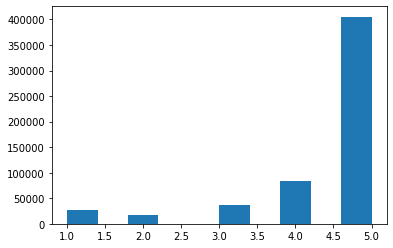

In [47]:
plt.hist(reviews['overall'])
plt.show()

Видим, что отзывов с оценкой "5" намного больше, чем всех остальных -- классы не сбалансированы

#### Смотрим на распределения остальных параметров (оси не приведены)

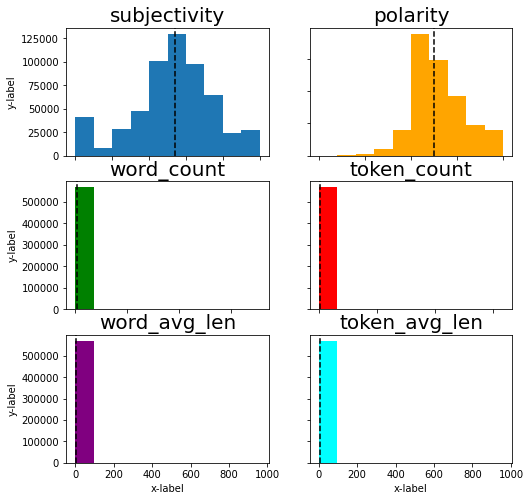

In [48]:
fig, axs = plt.subplots(3, 2, figsize = (8, 8))

axs[0, 0].hist(reviews['subjectivity'])
axs[0, 0].set_title('subjectivity', size=20)
axs[0, 0].axvline(reviews['subjectivity'].median(),color='black',ls='--') 

axs[0, 1].hist(reviews['polarity'], color = 'orange')
axs[0, 1].set_title('polarity',  size=20)
axs[0, 1].axvline(reviews['polarity'].median(),color='black',ls='--') 

axs[1, 0].hist(reviews['word_count'], color = 'green') 
axs[1, 0].set_title('word_count',  size=20)
axs[1, 0].axvline(reviews['word_count'].median(),color='black',ls='--') 

axs[1, 1].hist(reviews['token_count'], color = 'red')
axs[1, 1].set_title('token_count', size=20)
axs[1, 1].axvline(reviews['token_count'].median(),color='black',ls='--') 

axs[2, 0].hist(reviews['word_avg_len'], color = 'purple')
axs[2, 0].set_title('word_avg_len',  size=20)
axs[2, 0].axvline( reviews['word_avg_len'].median(),color='black',ls='--') 

axs[2, 1].hist(reviews['token_avg_len'], color = 'cyan')
axs[2, 1].set_title('token_avg_len', size=20)
axs[2, 1].axvline(reviews['token_avg_len'].median(),color='black',ls='--') 
               
for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

#### Для гистограм распределения длин и количества слов соответствующие значения прологарифмируем

### Слова и токены - количество

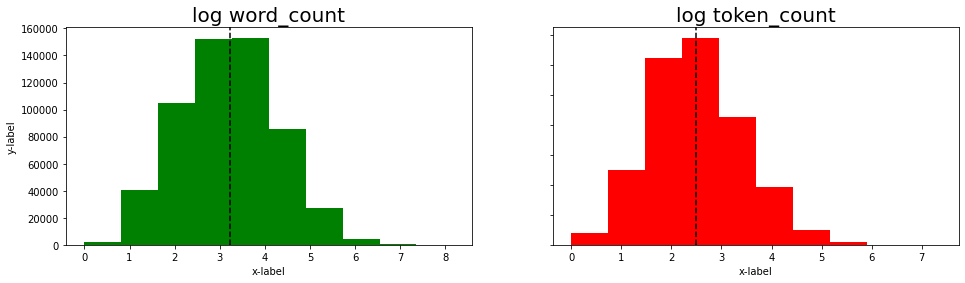

In [49]:
fig, axs = plt.subplots(1, 2, figsize = (16, 4))

axs[0].hist( np.log(1 + reviews['word_count']) , color = 'green') 
axs[0].set_title('log word_count',  size=20)
axs[0].axvline(np.log(1 + reviews['word_count']).median(),color='black',ls='--') 


axs[1].hist(np.log(1 + reviews['token_count']), color = 'red')
axs[1].set_title('log token_count', size=20)
axs[1].axvline(np.log(1 + reviews['token_count']).median(),color='black',ls='--') 

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

#### Смотрим зависимость от оценок

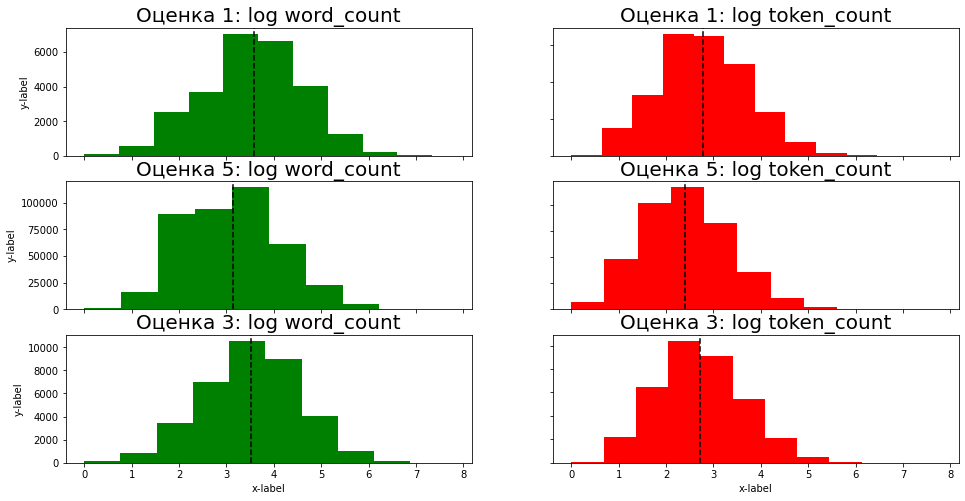

In [50]:
fig, axs = plt.subplots(3, 2, figsize = (16, 8), sharex = True)

axs[0, 0].hist( np.log(1 + reviews[reviews.overall == 1].word_count) , color = 'green') 
axs[0, 0].set_title('Оценка 1: log word_count',  size=20)
axs[0, 0].axvline(np.log(1 + reviews[reviews.overall == 1].word_count).median(),color='black',ls='--') 

axs[0, 1].hist(np.log(1 + reviews[reviews.overall == 1].token_count), color = 'red')
axs[0, 1].set_title('Оценка 1: log token_count', size=20)
axs[0, 1].axvline(np.log(1 + reviews[reviews.overall == 1].token_count).median(),color='black',ls='--') 

axs[1, 0].hist( np.log(1 + reviews[reviews.overall == 5].word_count) , color = 'green') 
axs[1, 0].set_title('Оценка 5: log word_count',  size=20)
axs[1, 0].axvline(np.log(1 + reviews[reviews.overall == 5].word_count).median(),color='black',ls='--') 

axs[1, 1].hist(np.log(1 + reviews[reviews.overall == 5].token_count), color = 'red')
axs[1, 1].set_title('Оценка 5: log token_count', size=20)
axs[1, 1].axvline(np.log(1 + reviews[reviews.overall == 5].token_count).median(),color='black',ls='--') 

axs[2, 0].hist( np.log(1 + reviews[reviews.overall == 3].word_count) , color = 'green') 
axs[2, 0].set_title('Оценка 3: log word_count',  size=20)
axs[2, 0].axvline(np.log(1 + reviews[reviews.overall == 3].word_count).median(),color='black',ls='--') 

axs[2, 1].hist(np.log(1 + reviews[reviews.overall == 3].token_count), color = 'red')
axs[2, 1].set_title('Оценка 3: log token_count', size=20)                            
axs[2, 1].axvline(np.log(1 + reviews[reviews.overall == 3].token_count).median(),color='black',ls='--') 
               
for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

#### Статистика

In [51]:
stats = pd.DataFrame()
stats['word_count_all'] = reviews.word_count.describe()
stats['word_count_1'] = reviews[reviews.overall == 1].word_count.describe()
stats['word_count_3'] = reviews[reviews.overall == 3].word_count.describe()
stats['word_count_5'] = reviews[reviews.overall == 5].word_count.describe()

stats['token_count_all'] = reviews.token_count.describe()
stats['token_count_1'] = reviews[reviews.overall == 1].token_count.describe()
stats['token_count_3'] = reviews[reviews.overall == 3].token_count.describe()
stats['token_count_5'] = reviews[reviews.overall == 5].token_count.describe()

print('Статистика по количеству слов в тексте и токенов:')
stats

Статистика по количеству слов в тексте и токенов:


,word_count_all,word_count_1,word_count_3,word_count_5,token_count_all,token_count_1,token_count_3,token_count_5
count,570612.000000,26050.000000,36343.000000,405415.000000,570612.000000,26050.000000,36343.000000,405415.000000
mean,42.526866,57.374894,55.389759,37.759153,18.718823,24.304338,22.914564,17.036141
std,62.043455,72.082067,73.732831,55.735940,26.710667,30.589278,31.363402,24.285662
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,17.000000,16.000000,9.000000,5.000000,7.000000,7.000000,5.000000
50%,24.000000,35.000000,33.000000,22.000000,11.000000,15.000000,14.000000,10.000000
75%,50.000000,71.000000,67.000000,44.000000,21.000000,30.000000,27.000000,19.000000
max,3551.000000,1539.000000,2088.000000,2403.000000,1592.000000,635.000000,904.000000,1106.000000


In [52]:
corr = reviews.corr()
corr.style.background_gradient(cmap='coolwarm')

,overall,polarity,subjectivity,review_len,word_count,word_avg_len,token_count,token_avg_len
overall,1,0.332631,0.138096,-0.110091,-0.113304,0.0436075,-0.0941618,0.0033652
polarity,0.332631,1,0.552924,-0.222121,-0.226196,0.0835388,-0.206469,0.00970188
subjectivity,0.138096,0.552924,1,-0.0536082,-0.0562892,0.0572053,-0.0443199,0.0227621
review_len,-0.110091,-0.222121,-0.0536082,1,0.998097,-0.0423629,0.989845,0.0231565
word_count,-0.113304,-0.226196,-0.0562892,0.998097,1,-0.0589958,0.985821,0.0110705
word_avg_len,0.0436075,0.0835388,0.0572053,-0.0423629,-0.0589958,1,-0.0385854,0.922587
token_count,-0.0941618,-0.206469,-0.0443199,0.989845,0.985821,-0.0385854,1,0.0122055
token_avg_len,0.0033652,0.00970188,0.0227621,0.0231565,0.0110705,0.922587,0.0122055,1


#### Выводы: 
Кол-во слов и токенов кореллируют с оценкой, но слабо и, вероятно, несущественно. А вот на polarity стоит будет взглянуть, но об этом дальше

### Слова и токены - средние длины

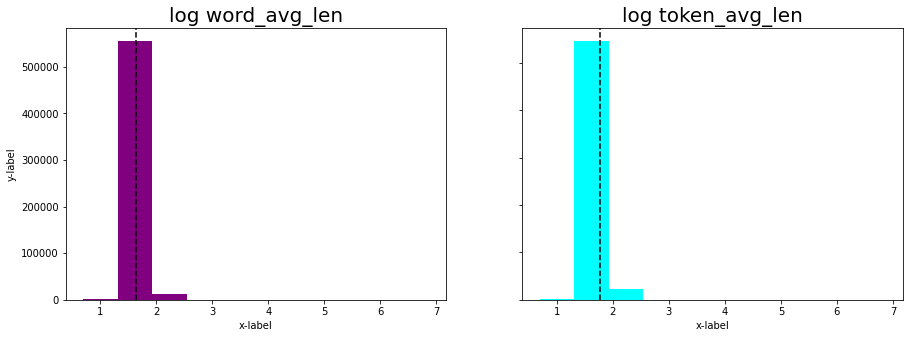

In [53]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))


axs[0].hist(np.log(1 + reviews['word_avg_len']), color = 'purple')
axs[0].set_title('log word_avg_len',  size=20)
axs[0].axvline(np.log(1 + reviews['word_avg_len']).median(),color='black',ls='--') 


axs[1].hist(np.log(1 + reviews['token_avg_len']), color = 'cyan')
axs[1].set_title('log token_avg_len', size=20)
axs[1].axvline(np.log(1 + reviews['token_avg_len']).median(),color='black',ls='--') 
                       
               
for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

#### Смотрим зависимость от оценок

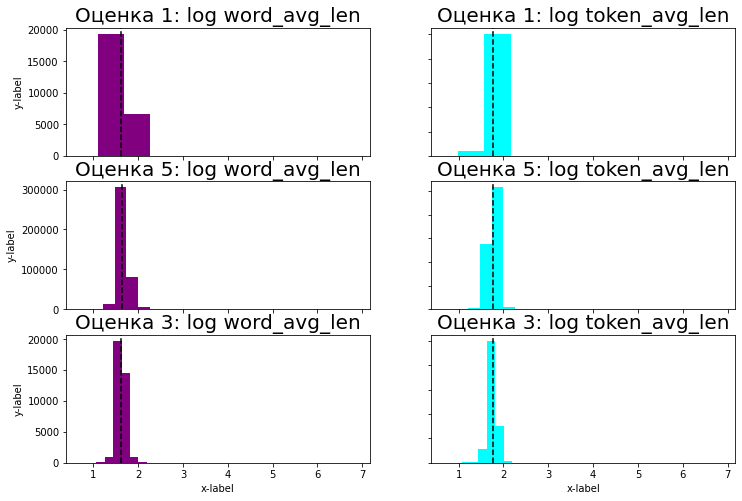

In [54]:
fig, axs = plt.subplots(3, 2, figsize = (12, 8), sharex = True)

axs[0, 0].hist(np.log(1 + reviews[reviews.overall == 1].word_avg_len), color = 'purple')
axs[0, 0].set_title('Оценка 1: log word_avg_len',  size=20)
axs[0, 0].axvline( np.log(1 + reviews[reviews.overall == 1].word_avg_len).median(),color='black',ls='--') 


axs[0, 1].hist(np.log(1 + reviews[reviews.overall == 1].token_avg_len), color = 'cyan')
axs[0, 1].set_title('Оценка 1: log token_avg_len', size=20)
axs[0, 1].axvline( np.log(1 + reviews[reviews.overall == 1].token_avg_len).median(),color='black',ls='--') 

axs[1, 0].hist(np.log(1 + reviews[reviews.overall == 5].word_avg_len), color = 'purple')
axs[1, 0].set_title('Оценка 5: log word_avg_len',  size=20)
axs[1, 0].axvline( np.log(1 + reviews[reviews.overall == 5].word_avg_len).median(),color='black',ls='--') 

axs[1, 1].hist(np.log(1 + reviews[reviews.overall == 5].token_avg_len), color = 'cyan')
axs[1, 1].set_title('Оценка 5: log token_avg_len', size=20)
axs[1, 1].axvline( np.log(1 + reviews[reviews.overall == 5].token_avg_len).median(),color='black',ls='--') 

axs[2, 0].hist(np.log(1 + reviews[reviews.overall == 3].word_avg_len), color = 'purple')
axs[2, 0].set_title('Оценка 3: log word_avg_len',  size=20)
axs[2, 0].axvline( np.log(1 + reviews[reviews.overall == 3].word_avg_len).median(),color='black',ls='--') 

axs[2, 1].hist(np.log(1 + reviews[reviews.overall == 3].token_avg_len), color = 'cyan')
axs[2, 1].set_title('Оценка 3: log token_avg_len', size=20)                                        
axs[2, 1].axvline( np.log(1 + reviews[reviews.overall == 3].token_avg_len).median(),color='black',ls='--') 

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

#### Статистика

In [55]:
stats = pd.DataFrame()
stats['word_len_all'] = reviews.word_avg_len.describe()
stats['word_len_1'] = reviews[reviews.overall == 1].word_avg_len.describe()
stats['word_len_3'] = reviews[reviews.overall == 3].word_avg_len.describe()
stats['word_len_5'] = reviews[reviews.overall == 5].word_avg_len.describe()

stats['token_len_all'] = reviews.token_avg_len.describe()
stats['token_len_1'] = reviews[reviews.overall == 1].token_avg_len.describe()
stats['token_len_3'] = reviews[reviews.overall == 3].token_avg_len.describe()
stats['token_len_5'] = reviews[reviews.overall == 5].token_avg_len.describe()

print('Статистика по средним значениям длин слов в тексте и токенов:')
stats

Статистика по средним значениям длин слов в тексте и токенов:


,word_len_all,word_len_1,word_len_3,word_len_5,token_len_all,token_len_1,token_len_3,token_len_5
count,570558.000000,26047.000000,36340.000000,405374.000000,569999.000000,26025.000000,36283.000000,404998.000000
mean,4.244968,4.162890,4.065181,4.292601,4.836726,4.859294,4.799938,4.844902
std,1.423435,5.947103,0.523089,0.682183,1.397271,5.947833,0.578347,0.604034
min,1.000000,2.000000,1.000000,1.000000,1.000000,1.666667,1.000000,1.000000
25%,3.863158,3.826923,3.772727,3.888889,4.500000,4.500000,4.500000,4.500000
50%,4.142857,4.079545,4.021978,4.181818,4.823529,4.826087,4.800000,4.833333
75%,4.500000,4.352193,4.300000,4.562500,5.144042,5.125000,5.100000,5.166667
max,960.000000,960.000000,12.000000,26.000000,960.000000,960.000000,12.000000,26.000000


In [56]:
corr = reviews.loc[:,['overall', 'word_avg_len', 'token_avg_len']].corr()
corr.style.background_gradient (cmap='coolwarm')

,overall,word_avg_len,token_avg_len
overall,1,0.0436075,0.0033652
word_avg_len,0.0436075,1,0.922587
token_avg_len,0.0033652,0.922587,1


#### Выводы: 
Вполне очевидно, почему кол-во слов в тексте и кол-во токенов коррелируют, как понятно и то, что средняя длина токена больше, чем средняя длина слова в тексте. Корреляция с таргетом практически нулевая

### Гистограмма: субъективность и эмоциональная оценка

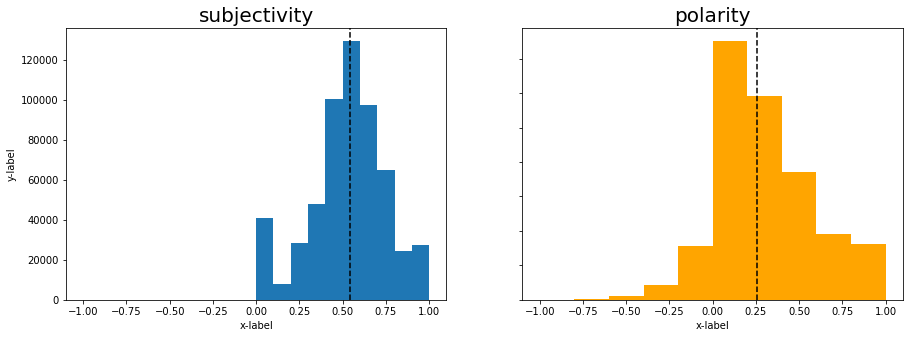

In [57]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5), sharex = True)

axs[0].hist(reviews['subjectivity'])
axs[0].set_title('subjectivity', size=20)
axs[0].axvline(reviews['subjectivity'].median(),color='black',ls='--') 

axs[1].hist(reviews['polarity'], color = 'orange')
axs[1].set_title('polarity',  size=20)
axs[1].axvline(reviews['polarity'].median(),color='black',ls='--') 

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

### Смотрим зависимость от оценок

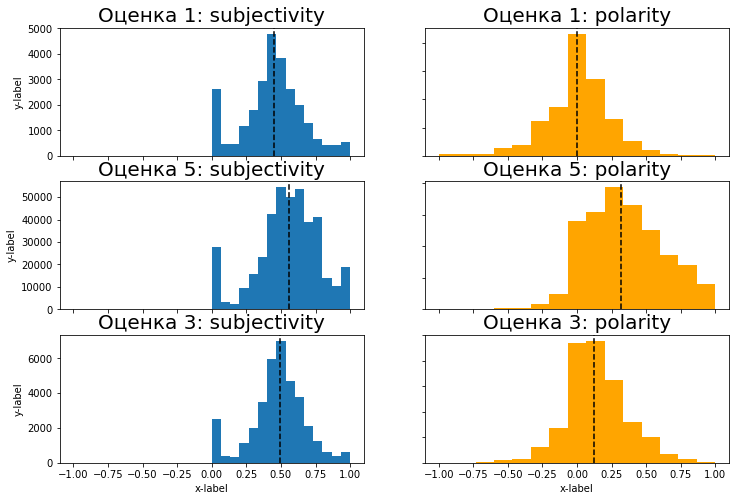

In [58]:
fig, axs = plt.subplots(3, 2, figsize = (12, 8), sharex = True)

axs[0, 0].hist( reviews[reviews.overall == 1].subjectivity , bins = 15) 
axs[0, 0].set_title('Оценка 1: subjectivity',  size=20)
axs[0, 0].axvline(reviews[reviews.overall == 1].subjectivity.median(),color='black',ls='--') 


axs[0, 1].hist(reviews[reviews.overall == 1].polarity, color = 'orange', bins = 15)
axs[0, 1].set_title('Оценка 1: polarity', size=20)
axs[0, 1].axvline(reviews[reviews.overall == 1].polarity.median(),color='black',ls='--') 


axs[1, 0].hist(reviews[reviews.overall == 5].subjectivity ,  bins = 15) 
axs[1, 0].set_title('Оценка 5: subjectivity',  size=20)
axs[1, 0].axvline(reviews[reviews.overall == 5].subjectivity.median(),color='black',ls='--') 

axs[1, 1].hist(reviews[reviews.overall == 5].polarity, color = 'orange', bins = 15)
axs[1, 1].set_title('Оценка 5: polarity', size=20)
axs[1, 1].axvline(reviews[reviews.overall == 5].polarity.median(),color='black',ls='--') 


axs[2, 0].hist(reviews[reviews.overall == 3].subjectivity , bins = 15) 
axs[2, 0].set_title('Оценка 3: subjectivity',  size=20)
axs[2, 0].axvline(reviews[reviews.overall == 3].subjectivity.median(),color='black',ls='--') 

axs[2, 1].hist(reviews[reviews.overall == 3].polarity, color = 'orange',bins = 15)
axs[2, 1].set_title('Оценка 3: polarity', size=20)
axs[2, 1].axvline(reviews[reviews.overall == 3].polarity.median(),color='black',ls='--')                              
               
for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [59]:
stats = pd.DataFrame()
stats['subjectivity_all'] = reviews.subjectivity.describe()
stats['subjectivity_1'] = reviews[reviews.overall == 1].subjectivity.describe()
stats['subjectivity_3'] = reviews[reviews.overall == 3].subjectivity.describe()
stats['subjectivity_5'] = reviews[reviews.overall == 5].subjectivity.describe()

stats['polarity_all'] = reviews.polarity.describe()
stats['polarity_1'] = reviews[reviews.overall == 1].polarity.describe()
stats['polarity_3'] = reviews[reviews.overall == 3].polarity.describe()
stats['polarity_5'] = reviews[reviews.overall == 5].polarity.describe()
stats

,subjectivity_all,subjectivity_1,subjectivity_3,subjectivity_5,polarity_all,polarity_1,polarity_3,polarity_5
count,570612.000000,26050.000000,36343.000000,405415.000000,570612.000000,26050.000000,36343.000000,405415.000000
mean,0.527300,0.434733,0.473361,0.544710,0.292534,0.006570,0.140460,0.345171
std,0.228331,0.222397,0.202331,0.231844,0.286077,0.231302,0.222146,0.282499
min,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.412500,0.330693,0.386111,0.429630,0.083434,-0.100000,0.000000,0.136364
50%,0.539744,0.447222,0.494061,0.561111,0.254167,0.000000,0.123333,0.316667
75%,0.675000,0.562500,0.592735,0.700000,0.475592,0.131235,0.256250,0.530000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [60]:
corr = reviews.loc[:,['overall', 'subjectivity', 'polarity']].corr()
corr.style.background_gradient (cmap='coolwarm')

,overall,subjectivity,polarity
overall,1,0.138096,0.332631
subjectivity,0.138096,1,0.552924
polarity,0.332631,0.552924,1


#### По гистограмме и корреляционной матрице можем предположить некоторую связь между оценкой и параметром polarity. Что тоже логично -- отзывы с низкой оценкой обычно имеют негативный окрас, отзывы с высокой - положительный :)

## Посмотрим на сами тексты

### Построим облака слов в форме звезды. Потому что рейтинг, потому что можем :)

In [0]:
from PIL import Image
star_mask = np.array(Image.open("Star.png"))
#star_mask

### Слова всех полных текстов (за вычетом стоп-слов)

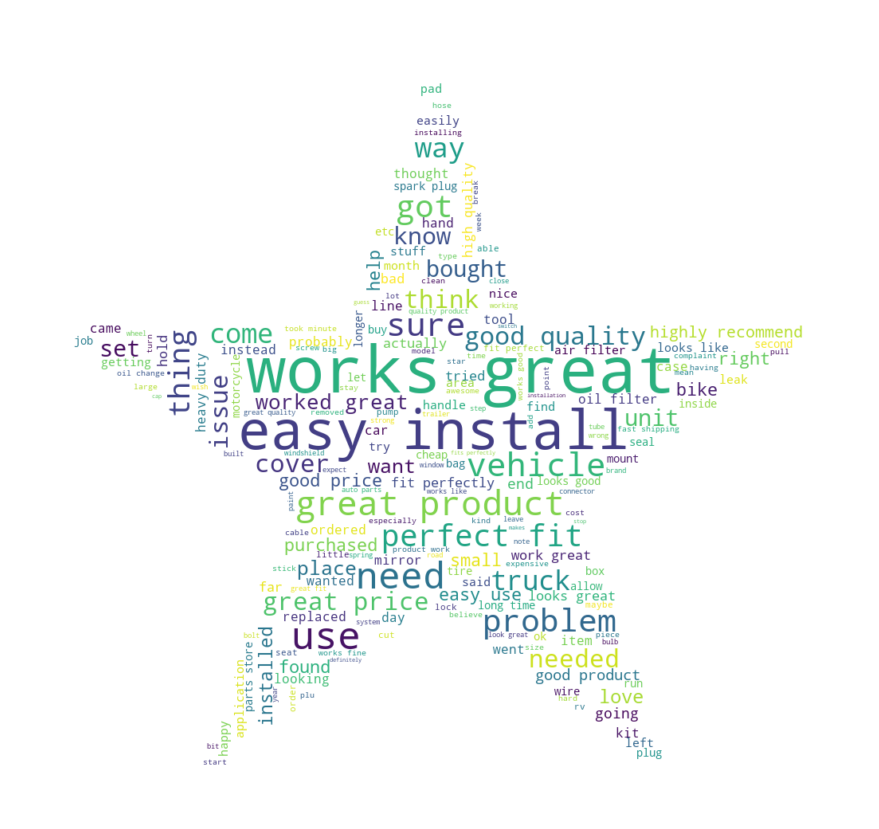

In [62]:
cloud = wordcloud.WordCloud(background_color='white',  
            relative_scaling=1,width=1600, height=800, mask = star_mask, stopwords = STOP_WORDS).generate(' '.join(reviews.reviewText))

fig = plt.figure(figsize=(30, 15))
plt.imshow(cloud, interpolation="bilinear")
plt.axis('off')

plt.show()

### Зависимость от оценки (токены)

In [0]:
#' '.join(reviews_short.reviewTokens.apply(lambda x: ' '.join(x)))

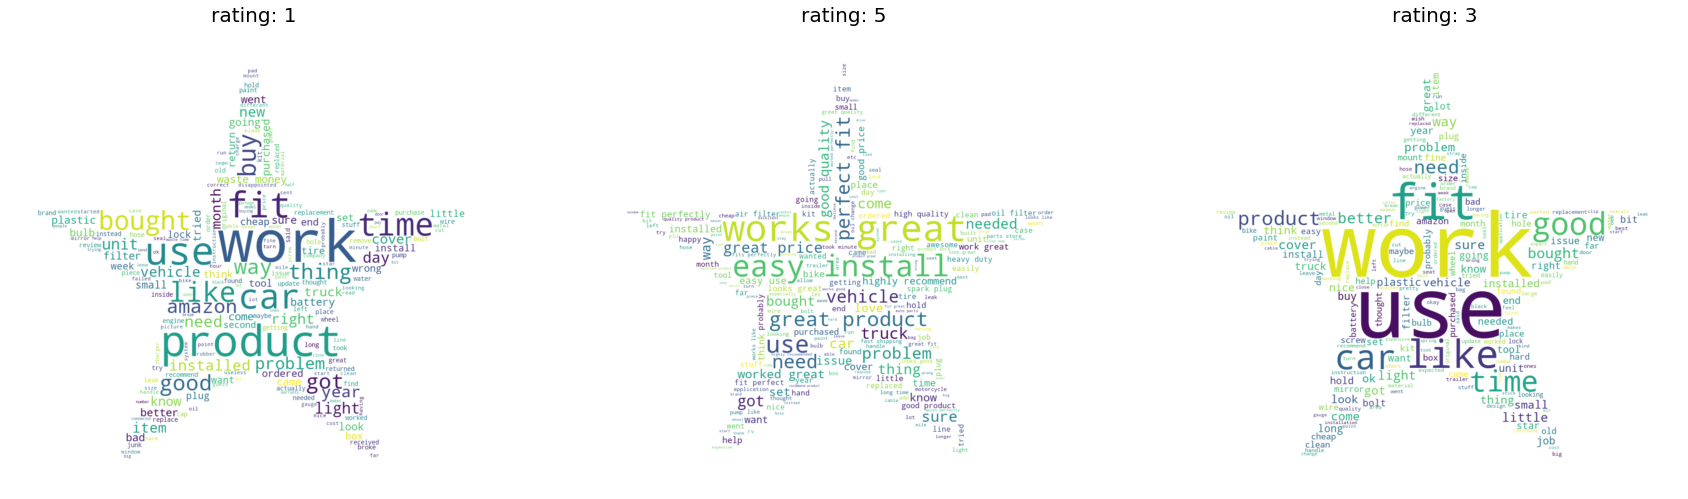

In [64]:
fig, axs = plt.subplots(1, 3, figsize = (30, 15), sharex = True)

cloud1 = wordcloud.WordCloud(background_color='white', relative_scaling=1,width=1600, height=800, 
            mask = star_mask, stopwords = STOP_WORDS).generate(' '.join(reviews.reviewText[reviews.overall == 1]))

#fig = plt.figure(figsize=(40, 20))
axs[0].imshow(cloud1, interpolation="bilinear")
axs[0].axis('off')
axs[0].set_title('rating: 1',  size=20)


cloud2 = wordcloud.WordCloud(background_color='white', relative_scaling=1,width=1600, height=800, 
            mask = star_mask, stopwords = STOP_WORDS).generate(' '.join(reviews.reviewText[reviews.overall == 5]))

#fig = plt.figure(figsize=(40, 20))
axs[1].imshow(cloud2, interpolation="bilinear")
axs[1].axis('off')
axs[1].set_title('rating: 5',  size=20)


cloud3 = wordcloud.WordCloud(background_color='white', relative_scaling=1,width=1600, height=800, 
            mask = star_mask, stopwords = STOP_WORDS).generate(' '.join(reviews.reviewText[reviews.overall == 3]))

#fig = plt.figure(figsize=(40, 20))
axs[2].imshow(cloud3, interpolation="bilinear")
axs[2].axis('off')
axs[2].set_title('rating: 3',  size=20)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

### Cмотрим статистику по словам

In [0]:
from nltk import ngrams, FreqDist
import functools

def list_of_tokens(tokenlist):
    tokens = []
    #tokens = functools.reduce(lambda x, y: x.extend(y), reviews_short.reviewTokens)
    for sub in tokenlist:
        for t in sub:
            tokens.append(t)
            
    return tokens

def sortFreqDict(freqdict):
    aux = [(freqdict[key], key) for key in freqdict]
    aux.sort()
    aux.reverse()
    return aux


In [66]:
#Все слова
token_counts = dict()
token_counts = FreqDist(ngrams(list_of_tokens(reviews.reviewTokens), 1))
print('Top-15 токенов в отзывах')
sortFreqDict(token_counts)[0:15]

Top-15 токенов в отзывах


[(181302, ('work',)),
 (149168, ('great',)),
 (119568, ('fit',)),
 (112596, ('good',)),
 (100305, ('instal',)),
 (96591, ('product',)),
 (95000, ('use',)),
 (85740, ('like',)),
 (77568, ('car',)),
 (74267, ('look',)),
 (68541, ('easi',)),
 (67949, ('need',)),
 (67263, ('perfect',)),
 (67247, ('time',)),
 (60859, ('replac',))]

In [67]:
# Обзоры с оценкой 1
token_counts = dict()
token_counts = FreqDist(ngrams(list_of_tokens(reviews[reviews.overall == 1].reviewTokens), 1))
print('Top-15 токенов в обзорах с оценкой 1')
sortFreqDict(token_counts)[0:15]

Top-15 токенов в обзорах с оценкой 1


[(7474, ('work',)),
 (7065, ('fit',)),
 (6362, ('product',)),
 (4837, ('time',)),
 (4481, ('use',)),
 (4266, ('buy',)),
 (4144, ('like',)),
 (3760, ('car',)),
 (3752, ('return',)),
 (3650, ('instal',)),
 (3542, ('tri',)),
 (3366, ('look',)),
 (3291, ('good',)),
 (3247, ('amazon',)),
 (3046, ('replac',))]

In [68]:
# Обзоры с оценкой 5
token_counts = dict()
token_counts = FreqDist(ngrams(list_of_tokens(reviews[reviews.overall == 5].reviewTokens), 1))
print('Top-15 токенов в обзорах с оценкой 5')
sortFreqDict(token_counts)[0:15]

Top-15 токенов в обзорах с оценкой 5


[(124643, ('great',)),
 (123170, ('work',)),
 (80476, ('fit',)),
 (73815, ('good',)),
 (72486, ('instal',)),
 (65948, ('product',)),
 (63269, ('use',)),
 (58558, ('perfect',)),
 (54955, ('easi',)),
 (54559, ('like',)),
 (54380, ('car',)),
 (49425, ('look',)),
 (46501, ('need',)),
 (44740, ('price',)),
 (43876, ('replac',))]

#### Видим, что самые частые отчасти слова отличаются для обзоров с разными оценками. В отзывах с положительной оценкой чаще пишут о лёгкости использования и слова одобрения, отзывы с негативной оценкой чаще содержат упоминания возврате, деньгах и факта покупки.  

### Балансировка классов. Undersampling

Готовим данные к построению модели. Как было выяснено раньше, в исходном датасете классы несбалансированы. Построим сбалансированную выборку, чтоб правильно выбрать самые важные токены

In [0]:
#rev_copy = reviews.copy(deep=True)
#rev_copy

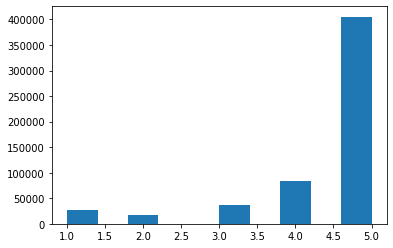

In [70]:
plt.hist(reviews.overall)
plt.show()

In [0]:
reviews = reviews.dropna() # могли появиться пустые наборы токенов -- для обучения всё равно не годны

In [0]:
from imblearn.under_sampling import RandomUnderSampler

X = reviews.drop('overall', axis = 1)
y = reviews.overall

undersample = RandomUnderSampler(sampling_strategy='not minority')
X_under, y_under = undersample.fit_resample(X, y)


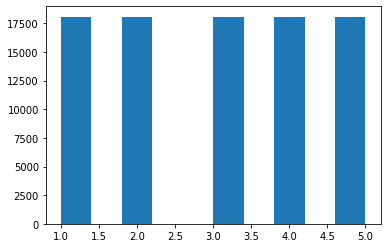

90380


In [73]:
plt.hist(y_under)
plt.show()
print (len(y_under))

Если все классы сокращать до размера самого маленького, то потеряем много данных (c 750k до примерно 90k тысяч). 

Но повторю то, что писала в самом начале ноутбука:
И ноуту, и колабу довольно тяжело справиться с объёмом данных, так что придётся уменьшить исходный датасет и согласиться на урезание классов до размера наименьшего

### Переводим наборы слов в числовые вектора

#### BoW

In [0]:
count_vect = CountVectorizer()
features_counts = count_vect.fit_transform(pd.DataFrame(X_under).loc[:,1].apply(lambda x: ' '.join(x)))
labels = y_under

#### TF-IDF

Оставляем не все токены, а только те, которые встречаются хотя бы в 20 документах, тем самым убирая редкие слова и опечатки.

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=20, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(pd.DataFrame(X_under).loc[:,1].apply(lambda x: ' '.join(x))).toarray()
labels = y_under
features.shape

(90380, 12300)

In [76]:
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Вычленим самые корреллируемые с оценкой токены и биграммы - пары токенов

In [77]:
from sklearn.feature_selection import chi2
import numpy as np
N = 10

features_chi2 = chi2(features, labels)
indices = np.argsort(features_chi2[0])
feature_names = np.array(tfidf.get_feature_names())[indices]
    
unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
bigrams = [v for v in feature_names if len(v.split(' ')) == 2]

print("Наиболее корреллируемые токены:\n-", '\n- '.join(unigrams[-N:]), '\n')
print("Наиболее корреллируемые биграммы:\n-", '\n- '.join(bigrams[-N:]))

Наиболее корреллируемые токены:
- money
- love
- garbag
- easi
- ok
- return
- junk
- wast
- perfect
- great 

Наиболее корреллируемые биграммы:
- wast time
- high recommend
- work perfect
- fit perfect
- great price
- great product
- easi instal
- perfect fit
- wast money
- work great


### Модель: TF-IDF + LinearSVC (44% точного предсказания/ 80.5% с ошибкой не более чем на 1 балл)

In [0]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
model = LinearSVC(random_state=42)
X_train, X_test, y_train, y_test,  = train_test_split(features, labels, test_size=0.1, random_state=57)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#### Оценим модель

In [79]:
conf = confusion_matrix(y_test, y_pred)
conf

array([[1022,  392,  167,   95,  102],
       [ 528,  553,  380,  185,  115],
       [ 267,  356,  578,  385,  190],
       [ 107,  196,  340,  700,  507],
       [  82,  102,  153,  412, 1124]])

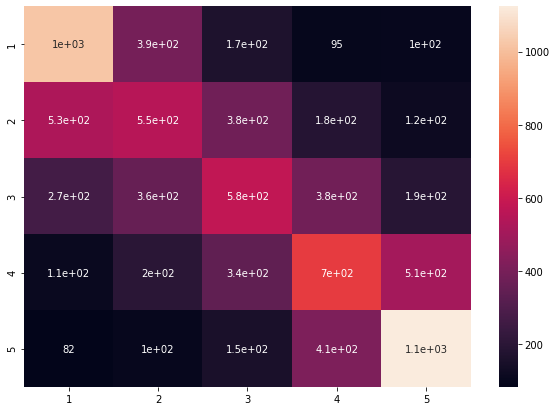

In [80]:
import seaborn as sns
df_cm = pd.DataFrame(conf, index = [i for i in range(1,6)],
                  columns = [i for i in range(1,6)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [81]:
sum(y_pred == y_test) / len(y_pred) * 100

44.00309803053773

In [82]:
sum(abs(y_pred - y_test)<=1) / len(y_pred) * 100

80.51560079663642

То есть наша модель точно предсказывает 42.64% оценок, а с погрешностью в 1 балл -- 79.9%

#### Примеры (подобраны вручную):

In [83]:
print(model.predict( tfidf.transform(["perfect thing easy to use"]) ))

[5]


In [84]:
print(model.predict( tfidf.transform(["This is the stupidest thing I've ever buy"]) ))

[1]


In [85]:
print(model.predict( tfidf.transform(["works fine"]) ))

[4]


In [86]:
print(model.predict( tfidf.transform(["i don't know it is just ok"]) ))

[3]


#### Даже некоторый сарказм можем распознать :D

In [87]:
print(model.predict( tfidf.transform(["This game is wonderful. Please refund"]) ))

[1]


### Модель: BoW + LinearSVC (42.7% / 78%)

In [0]:
model2 = LinearSVC(random_state=42)
X_train, X_test, y_train, y_test,  = train_test_split(features_counts, labels, test_size=0.1, random_state=57)
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)

In [89]:
conf = confusion_matrix(y_test, y_pred)
conf

array([[ 987,  364,  167,  127,  133],
       [ 521,  487,  381,  211,  161],
       [ 296,  320,  525,  379,  256],
       [ 127,  183,  316,  650,  574],
       [  83,  106,  131,  345, 1208]])

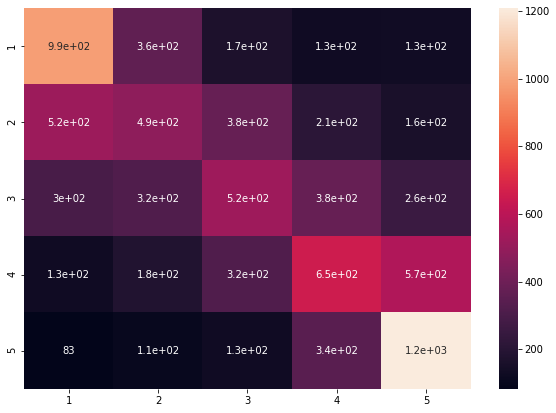

In [90]:
df_cm = pd.DataFrame(conf, index = [i for i in range(1,6)],
                  columns = [i for i in range(1,6)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [91]:
sum(y_pred == y_test) / len(y_pred) * 100

42.675370657225045

In [92]:
sum(abs(y_pred - y_test)<=1) / len(y_pred) * 100

78.08143394556318

Точность ниже

### Модель: TF-IDF + MultinomialNB (45% / 82%)

In [0]:
model3 = MultinomialNB()
X_train, X_test, y_train, y_test,  = train_test_split(features, labels, test_size=0.1, random_state=57)
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)

In [95]:
conf = confusion_matrix(y_test, y_pred)
conf

array([[1031,  417,  153,   72,  105],
       [ 505,  580,  424,  139,  113],
       [ 258,  363,  647,  348,  160],
       [ 100,  174,  400,  682,  494],
       [  90,  120,  144,  389, 1130]])

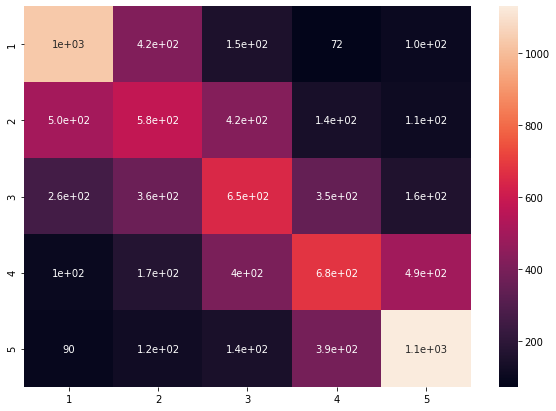

In [96]:
df_cm = pd.DataFrame(conf, index = [i for i in range(1,6)],
                  columns = [i for i in range(1,6)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [97]:
sum(y_pred == y_test) / len(y_pred) * 100

45.03208674485506

In [98]:
sum(abs(y_pred - y_test)<=1) / len(y_pred) * 100

81.98716530205797

Лучше!

### Выводы по моделям: 
#### Обеспечили точность 45%  (82% угадываются с погрешностью не более чем в 1 балл)
TF-IDF показывает себя лучше, чем Bag-of_words, 

Байес дал точность выше, чем опорные вектора

### Что можно улучшить/добавить

*   Построить другие статистики, более сложные
*   Использовать новые фичи для построения модели
*   Выбрать другие способы предобработки текста (например, другой список стоп-слов взять, рассматривать N-граммы в модели, другие способы векторизации текста, другой метод ресемплинга)
*   Рассмотреть другие модели, тщательно подобрать параметры к ним
*   Конечно, использовать полный датасет :)

Последние два пункта не удалось выполнить из-за ограниченности в мощности и объёмах памяти.